# Лабораторная работа №2
## Хрусталева Мария Олеговна
### 17-АС
#### Вариант 21


In [1]:
import pandas as pd 
import matplotlib.pyplot as plt
import numpy as np
from sklearn import preprocessing
from sklearn.metrics import precision_recall_curve, classification_report
from sklearn.metrics import auc, roc_curve, precision_recall_curve, average_precision_score
from sklearn.model_selection  import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
import seaborn as sns

import warnings
warnings.filterwarnings("ignore")

df = pd.read_csv('datatraining.txt')
df.head()


,date,Temperature,Humidity,Light,CO2,HumidityRatio,Occupancy
1,2015-02-04 17:51:00,23.18,27.2720,426.0,721.25,0.004793,1
2,2015-02-04 17:51:59,23.15,27.2675,429.5,714.00,0.004783,1
3,2015-02-04 17:53:00,23.15,27.2450,426.0,713.50,0.004779,1
4,2015-02-04 17:54:00,23.15,27.2000,426.0,708.25,0.004772,1
5,2015-02-04 17:55:00,23.10,27.2000,426.0,704.50,0.004757,1


### 1.	Изучить набор данных. Создать описание набора данных на русском языке. Описать признаки, используемые в наборе данных (включить полученные описания в отчёт).

| **Признак** | **Описание** |
|:------|:------|
| **date** | дата (год - месяц - день   час : минута : секунда)|
| **Temperature** |температура (по Цельсию)|
| **Humidity** | относительная влажность(%)|
| **Light** | освещенность (в люксах) |
| **CO2** | углекислый газ (в ppm) |
| **HumidityRatio** | коэфицент влажности (1 кг водянного пара / 1 кг воздуха) |
| **Occupancy** | занятость (0 - незанят, 1 - занят) |

### 2.	Удалите дубликаты строк в наборе данных;приведите размер набора данных до и после данной операции;

In [2]:
df.shape

(8143, 7)

In [3]:
df.drop_duplicates(inplace=True)
df.shape

(8143, 7)

### 3.	Оцените сбалансированность данных по классам (постройте гистограмму). Используйте полученную информацию при выборе метрики оценки качества классификации (PRили ROCкривая)

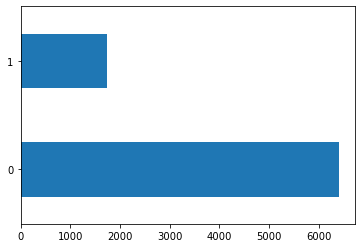

In [4]:
df.Occupancy.value_counts().plot.barh()
plt.show()

Видно, классы сильно не сбалансированны. Для оценки качества предпочтение следует отдавать PR-кривой, т.к она лучше ведет себя на несбалансированных классах.

### 4.	Выполните масштабирование количественных признаков;Постройте диаграммы BoxPlotдля признаков до и после масштабирования. Выберите способ масштабирования (например, нормализацию или стандартизацию);

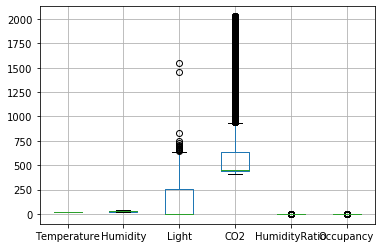

In [5]:
df.boxplot()
plt.show()

In [6]:
#Отдeлим числовые признаки
def data_normalize(df):
    numb_columns=[]
    cat_columns=[]
    for column in df.columns:
        if df[column].dtype.name!='object': numb_columns.append(column)
        else: cat_columns.append(column)
    return numb_columns, cat_columns

numb_columns, cat_columns=data_normalize(df)
#произведем нормализацию числовых признаков
scaler = preprocessing.MinMaxScaler()
df[numb_columns] = scaler.fit_transform(df[numb_columns])
df.head()

,date,Temperature,Humidity,Light,CO2,HumidityRatio,Occupancy
1,2015-02-04 17:51:00,1.000000,0.470533,0.275490,0.190933,0.557318,1.0
2,2015-02-04 17:51:59,0.992823,0.470332,0.277754,0.186446,0.554807,1.0
3,2015-02-04 17:53:00,0.992823,0.469326,0.275490,0.186136,0.553761,1.0
4,2015-02-04 17:54:00,0.992823,0.467315,0.275490,0.182887,0.551669,1.0
5,2015-02-04 17:55:00,0.980861,0.467315,0.275490,0.180566,0.547851,1.0


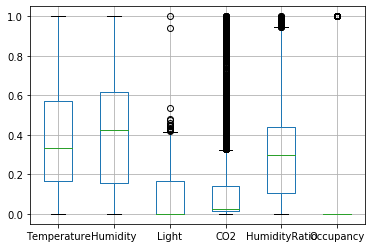

In [7]:
df.boxplot()
plt.show()

### 5.	Выполните замену категориальных признаков; выберите и обоснуйте способ замены;

Категориальные признаки отсутствуют

### 6.	Оцените корреляцию между признаками и удалите те признаки, которые коррелируют с наибольшим числом других (удалять признаки нужно только для линейных методов классификации);

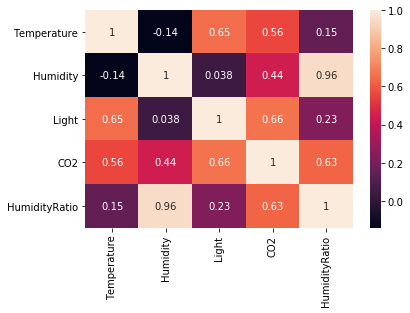

,Temperature,Humidity,Light,CO2,HumidityRatio
Temperature,1.000000,-0.141759,0.649942,0.559894,0.151762
Humidity,-0.141759,1.000000,0.037828,0.439023,0.955198
Light,0.649942,0.037828,1.000000,0.664022,0.230420
CO2,0.559894,0.439023,0.664022,1.000000,0.626556
HumidityRatio,0.151762,0.955198,0.230420,0.626556,1.000000


In [8]:
corr = df.drop('Occupancy', axis=1).corr()
sns.heatmap(corr, annot=True);
plt.show()
corr

### 7.	Заполните пропущенные значения в данных;

In [9]:
df.shape

(8143, 7)

In [10]:
df.count()

date             8143
Temperature      8143
Humidity         8143
Light            8143
CO2              8143
HumidityRatio    8143
Occupancy        8143
dtype: int64

Пропущенных значений нет

### 8.	Решите поставленную задачу классификации в соответствии с заданием. При подборе параметров классификатора используйте метод GridSearchCVи перекрёстную проверку (изучите возможные для изменения параметры классификации). Определите схему построения многоклассового классификатора, используемую по умолчанию (опишите используемую схему кодирования, обоснуйте свой выбор). Постройте, если это возможно, многоклассовую классификацию на основе схем «один-против-всех» и «все-против-всех».Оцените точность классификации для каждой их схем. Постройте кривые PRи ROC (для каждого из классов должны быть построены отдельные кривые, а также кривые для микро и макроусреднения метрик качества).Для линейного классификатора используйте регуляризацию.



In [11]:
df_test = pd.read_csv('datatest2.txt')
df_test.head()

,date,Temperature,Humidity,Light,CO2,HumidityRatio,Occupancy
1,2015-02-11 14:48:00,21.7600,31.133333,437.333333,1029.666667,0.005021,1
2,2015-02-11 14:49:00,21.7900,31.000000,437.333333,1000.000000,0.005009,1
3,2015-02-11 14:50:00,21.7675,31.122500,434.000000,1003.750000,0.005022,1
4,2015-02-11 14:51:00,21.7675,31.122500,439.000000,1009.500000,0.005022,1
5,2015-02-11 14:51:59,21.7900,31.133333,437.333333,1005.666667,0.005030,1


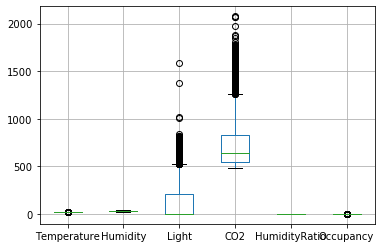

,date,Temperature,Humidity,Light,CO2,HumidityRatio,Occupancy
1,2015-02-11 14:48:00,0.462168,0.525565,0.276618,0.342373,0.700223,1.0
2,2015-02-11 14:49:00,0.468303,0.518004,0.276618,0.323736,0.695239,1.0
3,2015-02-11 14:50:00,0.463701,0.524950,0.274510,0.326092,0.700447,1.0
4,2015-02-11 14:51:00,0.463701,0.524950,0.277672,0.329704,0.700447,1.0
5,2015-02-11 14:51:59,0.468303,0.525565,0.276618,0.327296,0.703947,1.0


In [12]:
df_test.boxplot()
plt.show()
# выполняем нормализацию данных
numb_columns, cat_columns=data_normalize(df_test)
scaler = preprocessing.MinMaxScaler()
df_test[numb_columns] = scaler.fit_transform(df_test[numb_columns])
df_test.head()

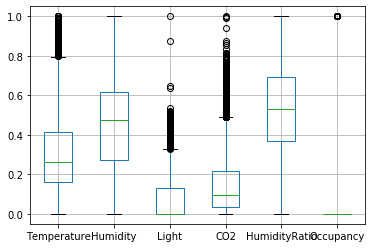

In [13]:
df_test.boxplot()
plt.show()

In [14]:
df_test.shape

(9752, 7)

In [15]:
df_test.count()

date             9752
Temperature      9752
Humidity         9752
Light            9752
CO2              9752
HumidityRatio    9752
Occupancy        9752
dtype: int64

Пропущенных значений нет

**Классификатор k ближайших соседей(задается количество ближайших объектов)**

In [16]:
X, Y = df[numb_columns + ['Occupancy']].drop('Occupancy', axis=1), df['Occupancy']
x_test, y_test = df_test[numb_columns + ['Occupancy']].drop('Occupancy', axis=1), df_test['Occupancy']

In [17]:
knn = KNeighborsClassifier()
#ищем оптимальные параметры для классификатора
knn_grid = GridSearchCV(knn, dict(n_neighbors = [elem for elem in range(1,50)]))
knn_grid.fit(X, Y)
selected_n_neighbors = knn_grid.best_estimator_.n_neighbors
best_score = knn_grid.best_score_
print('best train score - ', best_score,', at neighbors number - ', selected_n_neighbors)

#создаем и тренируем модель knn по оптимальным данным
knn = KNeighborsClassifier(n_neighbors=selected_n_neighbors)
knn.fit(X, Y)
#находим процент случаев, когда классификатор дает верный результат
best_score  = np.mean(y_test  == knn.predict(x_test))
print('test score - ', best_score)

best train score -  0.9328218726008781 , at neighbors number -  44
test score -  0.9487284659557014


**Логический классификатор(бинарное решающее дерево)**

In [18]:
#ищем оптимальную глубину и количество учитываемых параметров для классификатора решающее дерево
dtc = DecisionTreeClassifier()
params = {'max_depth': list(range(1,5)), 'max_features': list(range(1,5))}

dtc_grid = GridSearchCV(dtc, params)
dtc_grid.fit(X, Y)

best_features = dtc_grid.best_estimator_.max_features
best_depth = dtc_grid.best_estimator_.max_depth
best_score = dtc_grid.best_score_
print('best train score -  {}\nat features number - {}\nat depth - {}'.format(best_score,best_features,best_depth))

dtc = DecisionTreeClassifier(max_depth=best_depth, max_features=best_features)
dtc.fit(X, Y)
best_score  = np.mean(y_test == dtc.predict(x_test))
print('test score - ', best_score)
dtc.predict(x_test)


best train score -  0.9717610629212838
at features number - 3
at depth - 2
test score -  0.9861566858080394


array([1., 1., 1., ..., 1., 1., 1.])

In [19]:
y_test_invers = [1-y for y in y_test]

#### PR-кривые

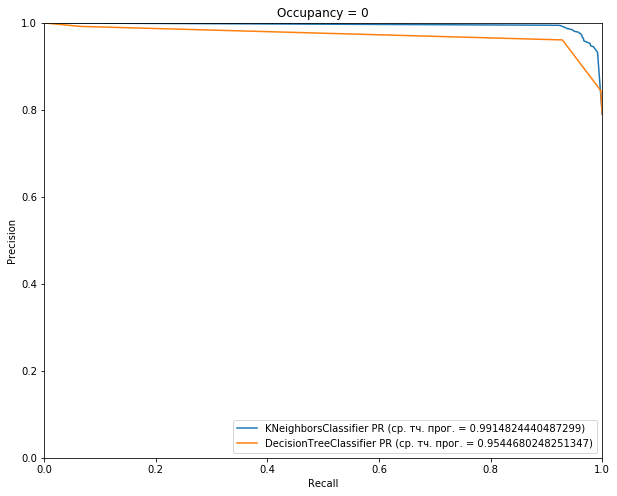

In [21]:
plt.figure(figsize=(10,8))
# k ближайших соседей
knn = KNeighborsClassifier(n_neighbors =selected_n_neighbors)
proba_knn0 = knn.fit(X, Y).predict_proba(x_test)
precision, recall, thresholds = precision_recall_curve(y_test_invers, proba_knn0[:,0])
aps_knn0 = average_precision_score(y_test_invers,proba_knn0[:,0])
plt.plot(recall, precision, label='KNeighborsClassifier PR (ср. тч. прог. = {})'.format(aps_knn0)) 

# логический классификатор
dtc = DecisionTreeClassifier(max_depth=best_depth, max_features=best_features)
proba_dtc0 = dtc.fit(X, Y).predict_proba(x_test)
precision, recall, thresholds = precision_recall_curve(y_test_invers, proba_dtc0[:,0])
aps_dtc0 = average_precision_score(y_test_invers,proba_dtc0[:,0])
plt.plot(recall, precision, label='DecisionTreeClassifier PR (ср. тч. прог. = {})'.format(aps_dtc0))

# вывод графика
def graf(xlabel,ylabel, title):
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.0])
    plt.legend(loc=4, fontsize='medium')
    plt.title(title)
    plt.show()

graf('Recall','Precision','Occupancy = 0')

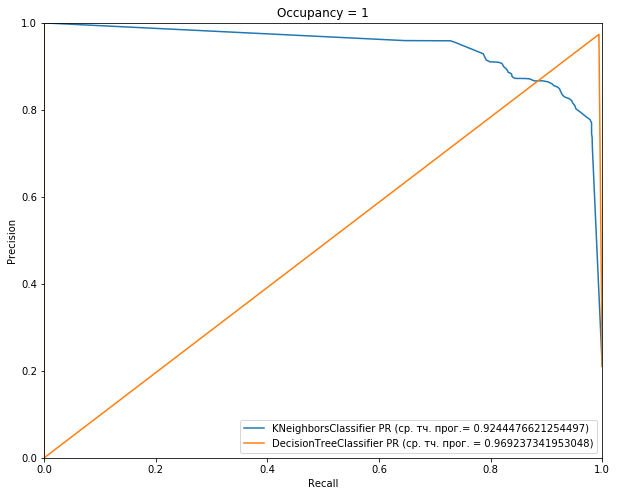

In [22]:
plt.figure(figsize=(10,8))
# K соседей
knn = KNeighborsClassifier(n_neighbors =selected_n_neighbors)
proba_knn1 = knn.fit(X, Y).predict_proba(x_test)
precision, recall, thresholds = precision_recall_curve(y_test, proba_knn1[:,1])
aps_knn1 = average_precision_score(y_test,proba_knn1[:,1])
plt.plot(recall, precision, label='KNeighborsClassifier PR (ср. тч. прог.= {})'.format(aps_knn1)) 
# логический классификатор
dtc = DecisionTreeClassifier(max_depth=best_depth, max_features=best_features)
proba_dtc1 = dtc.fit(X, Y).predict_proba(x_test)
precision, recall, thresholds = precision_recall_curve(y_test, proba_dtc1[:,1])
aps_dtc1 = average_precision_score(y_test,proba_dtc1[:,1])
plt.plot(recall, precision, label='DecisionTreeClassifier PR (ср. тч. прог. = {})'.format(aps_dtc1))

# вывод графика
graf('Recall','Precision','Occupancy = 1')

#### ROC-кривые

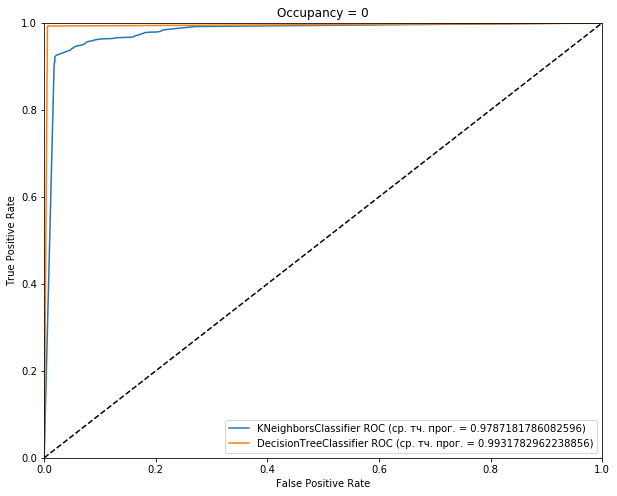

In [31]:
plt.figure(figsize=(10,8))
# K соседей
tpr, fpr, thresholds = roc_curve(y_test, proba_knn1[:,0])
roc_auc  = auc(fpr, tpr)
plt.plot(fpr, tpr, label='KNeighborsClassifier ROC (ср. тч. прог. = {})'.format(roc_auc)) 

# решающее дерево
tpr, fpr, thresholds = roc_curve(y_test, proba_dtc1[:,0])
roc_auc  = auc(fpr, tpr)
plt.plot(fpr, tpr, label='DecisionTreeClassifier ROC (ср. тч. прог. = {})'.format(roc_auc) )     

# вывод графика
plt.plot([0, 1], [0, 1], 'k--')
graf('False Positive Rate','True Positive Rate','Occupancy = 0')

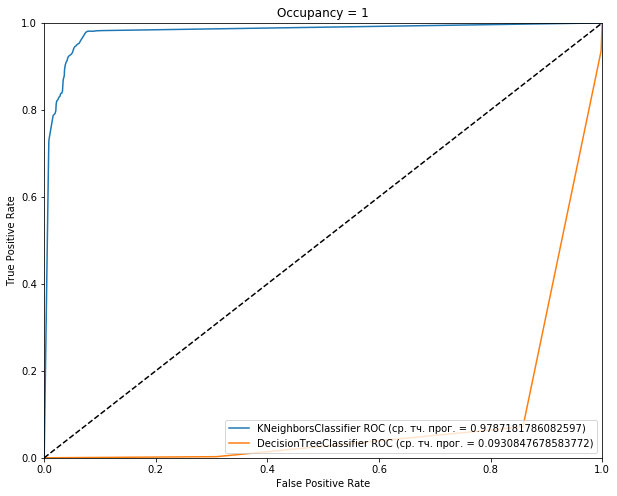

In [32]:
plt.figure(figsize=(10,8))
# K соседей
fpr, tpr, thresholds = roc_curve(y_test, proba_knn1[:,1])
roc_auc  = auc(fpr, tpr)
plt.plot(fpr, tpr, label='KNeighborsClassifier ROC (ср. тч. прог. = {})'.format(roc_auc)) 

# решающее дерево
tpr, fpr, thresholds = roc_curve(y_test, proba_dtc0[:,1])
roc_auc  = auc(fpr, tpr)
plt.plot(fpr, tpr, label='DecisionTreeClassifier ROC (ср. тч. прог. = {})'.format(roc_auc))   

# вывод графика
plt.plot([0, 1], [0, 1], 'k--')
graf('False Positive Rate','True Positive Rate','Occupancy = 1')

### 9.	Сравните кривые для классификаторов, указанных в задании, сделайте выводы.

Классификатор k ближайших соседей и логический классификатор имеют примерно одинаковые показатели качества относительно PR кривой.

Исходя из графиков ROC-кривых, классификатор k ближайших соседей лучше справляется с задачей классификации.
